# Project 2

In [22]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)


import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

from utils import generateDesignmatrix
from model_comparison import model_comparison
import algorithms
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

Calculating the coupeling coefficient J. 

Want to predict the energy with E = X*J

In [2]:
### define Ising model aprams
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states,L):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    J=np.zeros((L,L),)
    for i in range(L):
        J[i,(i+1)%L]-=1.0
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states,L)

"""
Comparing to project 1 - x = states, z = energies... 
Currently no y since we are in one dimension. 

"""

'\nComparing to project 1 - x = states, z = energies... \nCurrently no y since we are in one dimension. \n\n'

In [3]:
states.shape

(10000, 40)

In [4]:
energies.shape

(10000,)

## OBS OBS copy -- forklare hva som skjer her -- gir singular matrix i OLS

In [5]:
# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2])) 
# build final data set
Data=[states,energies]

# define number of samples
n_samples=400
# define train and test data sets
X_train=Data[0][:n_samples]
Y_train=Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
X_test=Data[0][n_samples:3*n_samples//2]
Y_test=Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])

In [6]:
ols = LinearRegression().fit(X_train, Y_train)
ols.coef_

array([ 0.01943949, -0.18352612, -0.04226814, ...,  0.0465506 ,
       -0.28527046,  0.        ])

In [7]:
X_train
X = X_train
y = Y_train
lmd = 0.1
u,s,vh = np.linalg.svd(X_train, full_matrices = False)
u.shape, s.shape, vh.shape

((400, 400), (400,), (400, 1600))

In [8]:
coef_ = X.T@y@np.linalg.inv(X.T@X + lmd*np.identity(X.shape[1]))
coef_


array([ 0.00290659, -0.1728435 , -0.05089638, ...,  0.04637133,
       -0.28561005,  0.00290659])

In [9]:
(X.T@y).shape

(1600,)

In [10]:
X.T@X + lmd*np.identity(X.shape[1])

array([[400.1, -10. , -14. , ...,  -2. ,  14. , 400. ],
       [-10. , 400.1,  20. , ...,  24. ,  -8. , -10. ],
       [-14. ,  20. , 400.1, ...,   0. ,   8. , -14. ],
       ...,
       [ -2. ,  24. ,   0. , ..., 400.1,  28. ,  -2. ],
       [ 14. ,  -8. ,   8. , ...,  28. , 400.1,  14. ],
       [400. , -10. , -14. , ...,  -2. ,  14. , 400.1]])

In [11]:
Y_train.shape

(400,)

In [38]:
# Experimental setup
models = {
    "ols": algorithms.OLS,
    #"ols": LinearRegression,
    'ridge': algorithms.Ridge, 
    "lasso": algorithms.Lasso
}
param_grid = {
    'ols': [0],
    'ridge': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000, 100000],  
    'lasso': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000, 100000]
}


results, z_pred_best = model_comparison(
    models, param_grid, X_train, Y_train, split_size=0.2
    )

Testing model: ols
0
Testing model: ridge
5
Testing model: lasso
1


In [39]:
results

{'mse_test': {'lasso': [[35.09644393888305,
    8.008633987846418e-05,
    0.007866144137519942,
    0.7855027735851123,
    35.61811597790815,
    39.802499999999995,
    39.802499999999995,
    39.802499999999995,
    39.802499999999995,
    39.802499999999995]],
  'ols': [[25.050701595433132]],
  'ridge': [[25.050701207066673,
    25.050698194310748,
    25.050667603419292,
    25.050362129014424,
    25.04735252743228,
    25.02153122787039,
    25.033704349269904,
    28.009083493976114,
    36.08085331255271,
    39.15513012916411]]},
 'mse_train': {'lasso': [[3.879828784476512e-06,
    5.163746668419624e-05,
    0.005112350046471278,
    0.510846005093575,
    29.262654619926877,
    35.7975,
    35.7975,
    35.7975,
    35.7975,
    35.7975]],
  'ols': [[2.389001340680336e-28]],
  'ridge': [[3.0658664535005684e-13,
    3.097466218865518e-11,
    3.0971217631193057e-09,
    3.0960032980163547e-07,
    3.0849270857198624e-05,
    0.002978381915960594,
    0.22112967509351944,
  

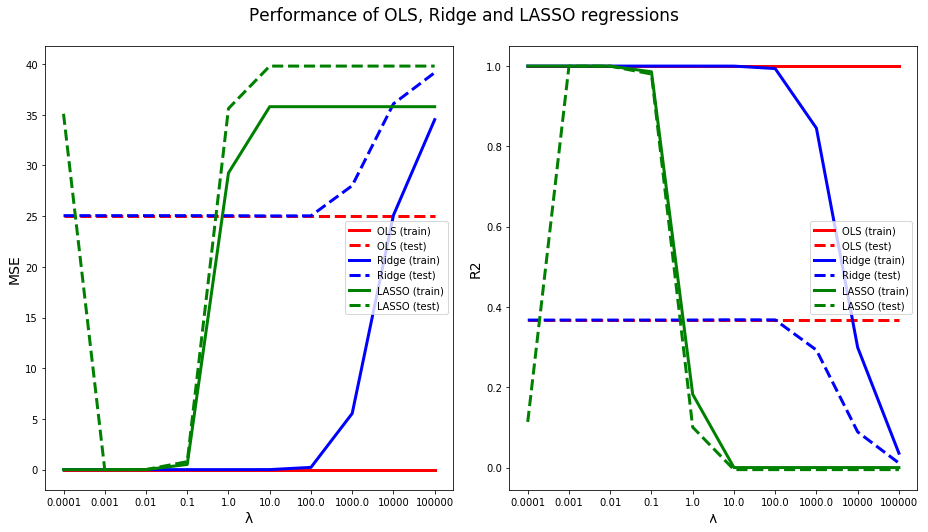

In [46]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions", y=1.05, fontsize=17)

#plt.savefig("results/figures/franke/performance/performance_p5.png")
plt.tight_layout()    
plt.show()

The above figure is similar to the one in the notebook from metha et al.

In [45]:
ols = z_pred_best["ols"]
ridge = z_pred_best["ridge"]
lasso = z_pred_best["lasso"]
ols.shape

(80,)

In [48]:
ols

array([ 1.12697774,  2.11722628, -0.9228329 ,  2.50667314, -6.29790192,
        1.01035803, -4.3561449 ,  0.31302094, -3.59214428, -0.96840303,
        2.55591966,  3.26613398,  4.04635789, -7.5493025 , -4.74046904,
        3.49838814,  1.75838804, -4.01998758,  4.71662722, -4.03244548,
       -1.74961878,  7.09579448,  2.13310405, -0.19758565,  1.26041863,
       -1.75771422,  1.53399575,  3.84308395,  6.05765422,  7.48764148,
       -6.13437349,  2.97122146,  4.09169743,  4.65342782,  0.1430361 ,
       -2.48472715, -0.37510141, -2.69036551, -0.31076816,  1.43549762,
       -6.93919806,  3.8742119 ,  0.7644756 ,  1.41196935, -0.39500569,
       -1.1259686 ,  2.76182805,  1.8217726 , -5.09606258,  4.9099753 ,
        8.6833006 ,  3.27778455, -2.44981406,  0.18955925, -4.94612782,
       -3.34031599,  2.10208899, -5.30026581, -4.77187365,  5.16933595,
       -1.35047349,  0.45233927, -1.6867737 , -1.54037591,  1.02108122,
        6.19768411, -6.1920932 , -0.75886614, -1.05821202, -7.72

# Creating svd -- testing.

In [14]:
A = np.concatenate([[1,2,3], [9,7,2], [6,1,4]]).reshape((3, 3))

In [15]:
#def svd(A):
" returns the singular value decomposition of a matrix A = U@D@V.T"
# calculate eigenvalues and eigenvectores.
nrows, ncols = np.shape(A)
u,V = np.linalg.eig(A.T@A)
# u is a vector of eigenvalues
# v is a vecort of eigenvectores.
s = np.sqrt(u) # singular values is the
D = np.identity(ncols)*s

print(D*s)

# D-1 is equal to 1/dii for all elements in D.
U = A@V@np.linalg.inv(D)
U, D, V

[[180.89394831   0.           0.        ]
 [  0.           5.56677984   0.        ]
 [  0.           0.          14.53927185]]


(array([[ 0.20589536, -0.91983107,  0.33394297],
        [ 0.8474132 , -0.00306607, -0.5309251 ],
        [ 0.4893853 ,  0.39230269,  0.7788457 ]]),
 array([[13.44968209,  0.        ,  0.        ],
        [ 0.        ,  2.35940243,  0.        ],
        [ 0.        ,  0.        ,  3.81303971]]),
 array([[ 0.80068256,  0.5960791 ,  0.0599761 ],
        [ 0.50804683, -0.62253979, -0.59525845],
        [ 0.31748361, -0.50708373,  0.80129286]]))

In [16]:
U.T@U # identity

array([[ 1.00000000e+00, -1.96158547e-15, -1.17134204e-16],
       [-1.96158547e-15,  1.00000000e+00,  2.26946395e-15],
       [-1.17134204e-16,  2.26946395e-15,  1.00000000e+00]])

In [17]:
V.T@V # this is close to the identity. 

array([[ 1.00000000e+00, -3.05423406e-16, -1.15137686e-16],
       [-3.05423406e-16,  1.00000000e+00,  1.47285696e-15],
       [-1.15137686e-16,  1.47285696e-15,  1.00000000e+00]])

In [18]:
A

array([[1, 2, 3],
       [9, 7, 2],
       [6, 1, 4]])

In [19]:
U@D@V.T

array([[1., 2., 3.],
       [9., 7., 2.],
       [6., 1., 4.]])

In [20]:
np.allclose(A,  U@D@V.T)

True

# Download to dim data

In [52]:
import pickle
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as skms
import sklearn.linear_model as skl
import sklearn.metrics as skm
import tqdm
import copy
import time
from IPython.display import display

%matplotlib inline

sns.set(color_codes=True)



In [53]:
filenames = glob.glob(os.path.join("..", "dat", "*"))
label_filename = list(filter(lambda x: "label" in x, filenames))[0]
dat_filename = list(filter(lambda x: "label" not in x, filenames))[0]

# Read in the labels
with open(label_filename, "rb") as f:
    labels = pickle.load(f)

# Read in the corresponding configurations
with open(dat_filename, "rb") as f:
    data = np.unpackbits(pickle.load(f)).reshape(-1, 1600).astype("int")

# Set spin-down to -1
data[data == 0] = -1

IndexError: list index out of range